Epoch 1/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.4953 - loss: 0.2080 - val_accuracy: 0.1948 - val_loss: 0.0956
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.5001 - loss: 0.1180 - val_accuracy: 0.1948 - val_loss: 0.0863
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5052 - loss: 0.1100 - val_accuracy: 0.1948 - val_loss: 0.0893
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.4967 - loss: 0.1052 - val_accuracy: 0.1948 - val_loss: 0.0923
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5010 - loss: 0.0995 - val_accuracy: 0.1948 - val_loss: 0.0759
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4968 - loss: 0.0931 - val_accuracy: 0.1953 - val_loss: 0.0863
Epoch 7/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5268 - loss: 0.0857 - val_accuracy: 0.2274 - val_loss: 0.0826
Epoch 8/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5664 - loss: 0.0830 - val_acc

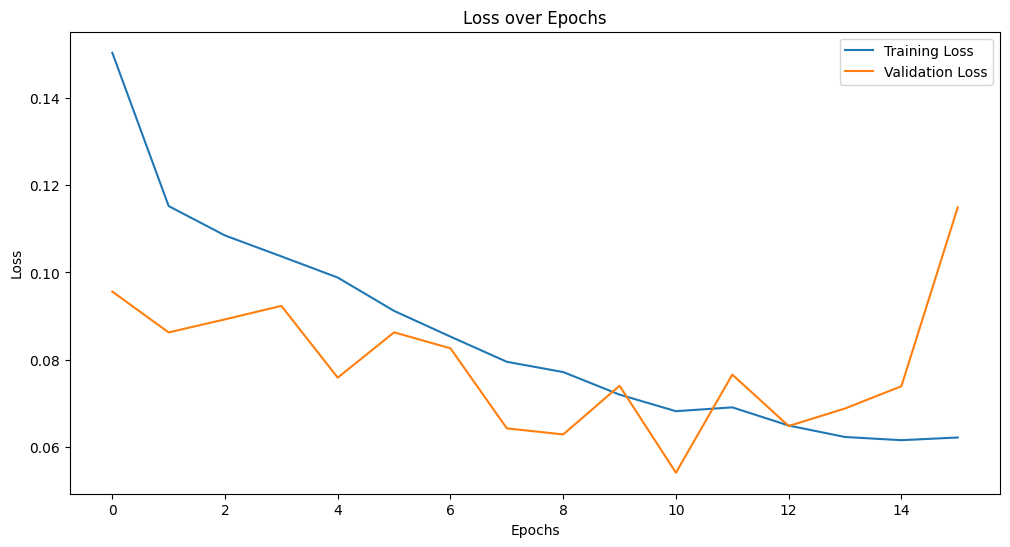

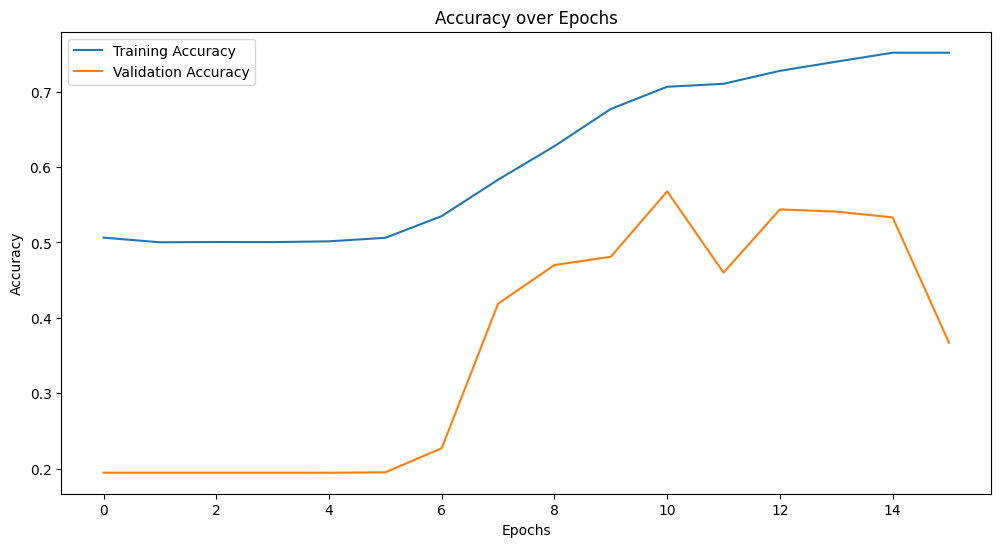

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import backend as K

# Load and preprocess datasets

# Load datasets
train_data = pd.read_csv("BATADAL_dataset04.csv")
test_data = pd.read_csv("BATADAL_test_dataset.csv")

# Replace -999 with 0
train_data = train_data.replace(-999, 0)
test_data = test_data.replace(-999, 0)

# Extract and preprocess the datetime column (first column)
train_data.iloc[:, 0] = pd.to_datetime(train_data.iloc[:, 0], format="%d/%m/%y %H")
test_data.iloc[:, 0] = pd.to_datetime(test_data.iloc[:, 0], format="%d/%m/%y %H")

# Drop the datetime column (first column) and separate the label (last column)
train_labels = train_data.iloc[:, -1]  # Last column as labels
test_labels = test_data.iloc[:, -1]

train_data = train_data.iloc[:, 1:-1]  # Remove the first (datetime) and last (label) columns
test_data = test_data.iloc[:, 1:-1]

# Normalize data using training set statistics
min_val = train_data.min().min()
max_val = train_data.max().max()
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

# Address class imbalance using SMOTE

# Convert training data to arrays for SMOTE
X_train_flat = train_data.values
y_train_flat = train_labels.values

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train_flat)

# Reshape training data for Transformer input
time_steps = 1  # Assuming one timestep
X_train_resampled = X_train_resampled.reshape(-1, time_steps, train_data.shape[1])
y_train_resampled = tf.keras.utils.to_categorical(y_train_resampled, num_classes=2)

# Process test data
X_test = test_data.values.reshape(-1, time_steps, test_data.shape[1])
y_test = tf.keras.utils.to_categorical(test_labels.values, num_classes=2)

# Define Focal Loss for imbalanced data

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# Build Transformer Model

def transformer_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Positional Encoding
    positional_encoding = layers.Dense(64, activation="relu")(inputs)

    # Multi-Head Attention
    attention_output = layers.MultiHeadAttention(num_heads=8, key_dim=64)(positional_encoding, positional_encoding)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output)

    # Feed-Forward Network
    x = layers.Dense(128, activation="relu")(attention_output)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    # Global Pooling and Output
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)

# Instantiate the Transformer model
transformer = transformer_model((time_steps, train_data.shape[1]), num_classes=2)

# Compile the Transformer model
transformer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss(alpha=0.25, gamma=2),
    metrics=["accuracy"]
)

# Train the Transformer Model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

history = transformer.fit(
    X_train_resampled,
    y_train_resampled,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight={0: 1.0, 1: 10.0},  # Higher weight for minority class
    callbacks=[early_stopping]
)

# Evaluate the Model

# Predict on the test dataset
y_pred_probs = transformer.predict(X_test)

# Find optimal threshold using Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(np.argmax(y_test, axis=1), y_pred_probs[:, 1])
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
y_pred = (y_pred_probs[:, 1] > optimal_threshold).astype(int)
y_true = np.argmax(y_test, axis=1)

# Metrics calculation
def print_stats(y_pred, y_true):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=1))
    print("Recall:", recall_score(y_true, y_pred, zero_division=1))
    print("F1 Score:", f1_score(y_true, y_pred, zero_division=1))

print_stats(y_pred, y_true)

# Plot Training History

plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()